In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os


In [8]:
# Dataset directory
train_dir = "C:\\Users\\haika\\AppData\\Local\\Programs\\Microsoft VS Code\\data\\split_data\\train"
val_dir = "C:\\Users\\haika\\AppData\\Local\\Programs\\Microsoft VS Code\\data\\split_data\\val"
test_dir = "C:\\Users\\haika\\AppData\\Local\\Programs\\Microsoft VS Code\\data\\split_data\\test"

# Model parameters
num_classes = 10  # Specify the number of classes in your dataset
input_shape = (224, 224, 3)  # Input shape expected by DenseNet121

# Training parameters
batch_size = 20
epochs = 50
learning_rate = 0.001


In [9]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 3649 images belonging to 10 classes.
Found 782 images belonging to 10 classes.


In [10]:
# Load pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Add GlobalAveragePooling2D layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add Dense layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(lr=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


c:\Users\haika\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# Load best model
model = tf.keras.models.load_model('best_model.h5')

# Train the model without early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,  # Train for exactly 50 epochs
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard]  # Keep other callbacks if needed
)


Epoch 1/50
183/183 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.9372
Epoch 1: val_accuracy did not improve from 0.89514
183/183 [==============================] - 58s 283ms/step - loss: 0.1837 - accuracy: 0.9372 - val_loss: 0.6130 - val_accuracy: 0.8427
Epoch 2/50
183/183 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9348
Epoch 2: val_accuracy did not improve from 0.89514
183/183 [==============================] - 49s 264ms/step - loss: 0.2008 - accuracy: 0.9348 - val_loss: 0.6037 - val_accuracy: 0.8376
Epoch 3/50
183/183 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.9422
Epoch 3: val_accuracy did not improve from 0.89514
183/183 [==============================] - 49s 268ms/step - loss: 0.1759 - accuracy: 0.9422 - val_loss: 0.6410 - val_accuracy: 0.8210
Epoch 4/50
183/183 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.9233
Epoch 4: val_accuracy did not improve from 0.89514
183/183 [=

Found 782 images belonging to 10 classes.
40/40 [==============================] - 10s 215ms/step


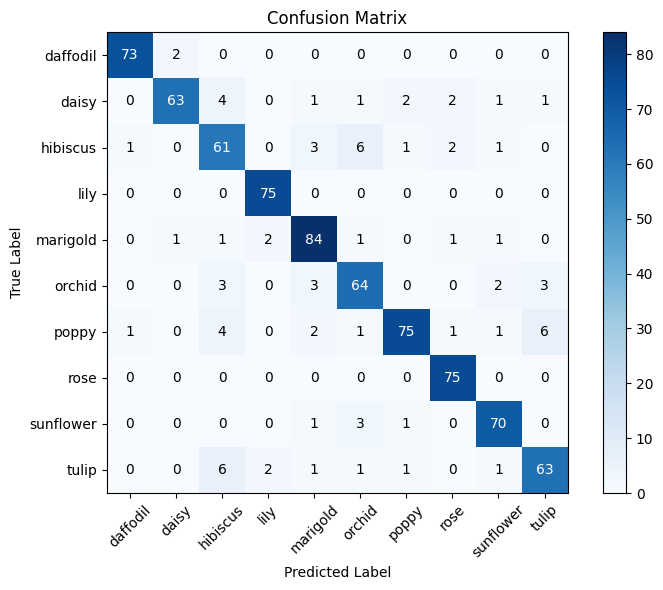

              precision    recall  f1-score   support

    daffodil       0.97      0.97      0.97        75
       daisy       0.95      0.84      0.89        75
    hibiscus       0.77      0.81      0.79        75
        lily       0.95      1.00      0.97        75
    marigold       0.88      0.92      0.90        91
      orchid       0.83      0.85      0.84        75
       poppy       0.94      0.82      0.88        91
        rose       0.93      1.00      0.96        75
   sunflower       0.91      0.93      0.92        75
       tulip       0.86      0.84      0.85        75

    accuracy                           0.90       782
   macro avg       0.90      0.90      0.90       782
weighted avg       0.90      0.90      0.90       782



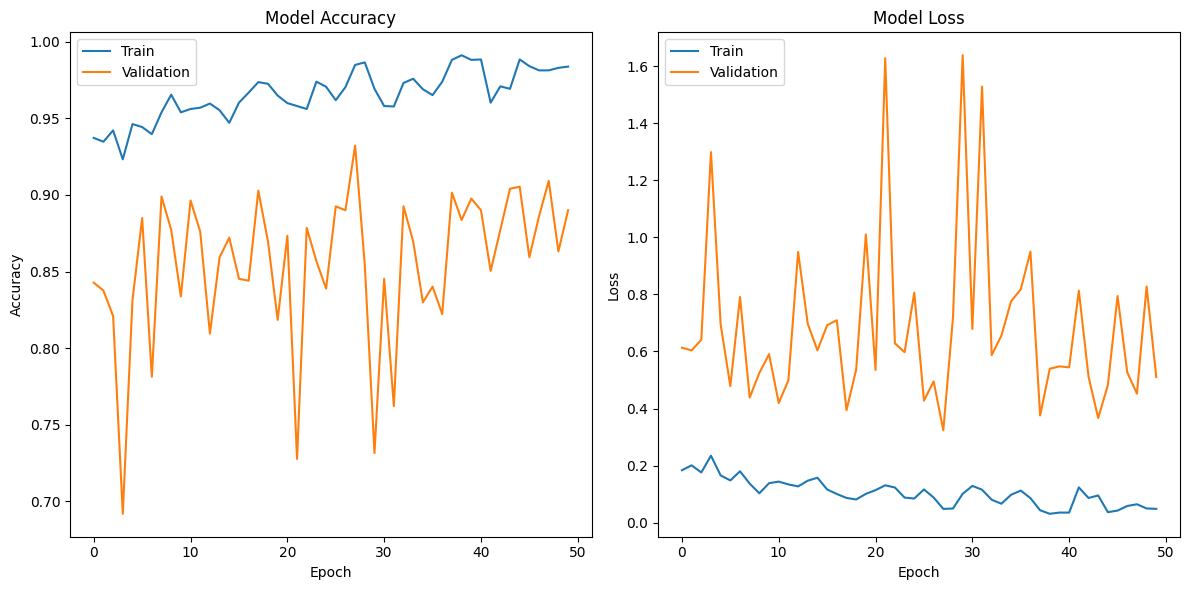

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load best model
model = tf.keras.models.load_model('best_model.h5')

# Evaluate on test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix with numerical annotations
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [13]:
# Assuming `history` object is available after training
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')


Final Training Loss: 0.0483
Final Validation Loss: 0.5100


In [14]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


40/40 [==============================] - 11s 238ms/step - loss: 0.4208 - accuracy: 0.8990
Test Loss: 0.4208
Test Accuracy: 0.8990


In [6]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, MobileNetV3Small, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import pandas as pd


In [7]:
# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\haika\\AppData\\Local\\Programs\\Microsoft VS Code\\data\\split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators without additional preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3649 images belonging to 10 classes.
Found 782 images belonging to 10 classes.
Found 782 images belonging to 10 classes.


In [9]:
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'model' is your trained DenseNet121 model loaded from 'best_model.h5'
model = tf.keras.models.load_model('best_model.h5')

# Assuming 'test_generator' is your test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'C:\\Users\\haika\\AppData\\Local\\Programs\\Microsoft VS Code\\data\\split_data\\test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate on test set
start_time = time.time()
loss, accuracy = model.evaluate(test_generator)
end_time = time.time()
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nAccuracy: {accuracy:.4f}")

# Classification Report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Training time
training_time = end_time - start_time
print(f"\nTraining Time: {training_time:.2f} seconds")


Found 782 images belonging to 10 classes.
25/25 [==============================] - 4s 90ms/step - loss: 0.4208 - accuracy: 0.8990
Test Loss: 0.4208
Test Accuracy: 0.8990
25/25 [==============================] - 4s 88ms/step

Accuracy: 0.8990

Classification Report:
              precision    recall  f1-score   support

    daffodil       0.97      0.97      0.97        75
       daisy       0.95      0.84      0.89        75
    hibiscus       0.77      0.81      0.79        75
        lily       0.95      1.00      0.97        75
    marigold       0.88      0.92      0.90        91
      orchid       0.83      0.85      0.84        75
       poppy       0.94      0.82      0.88        91
        rose       0.93      1.00      0.96        75
   sunflower       0.91      0.93      0.92        75
       tulip       0.86      0.84      0.85        75

    accuracy                           0.90       782
   macro avg       0.90      0.90      0.90       782
weighted avg       0.90      0

Found 3649 images belonging to 10 classes.
Found 782 images belonging to 10 classes.
Found 782 images belonging to 10 classes.
Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 4.7936 - accuracy: 0.2587
Epoch 1: val_accuracy improved from -inf to 0.38107, saving model to best_densenet121_model.h5
115/115 [==============================] - 44s 324ms/step - loss: 4.7936 - accuracy: 0.2587 - val_loss: 1.7322 - val_accuracy: 0.3811
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 1.9306 - accuracy: 0.3423
Epoch 2: val_accuracy improved from 0.38107 to 0.45524, saving model to best_densenet121_model.h5
115/115 [==============================] - 35s 306ms/step - loss: 1.9306 - accuracy: 0.3423 - val_loss: 1.5627 - val_accuracy: 0.4552
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 1.7912 - accuracy: 0.3804
Epoch 3: val_accuracy improved from 0.45524 to 0.46419, saving model to best_densenet121_model.h5
115/115 [=================

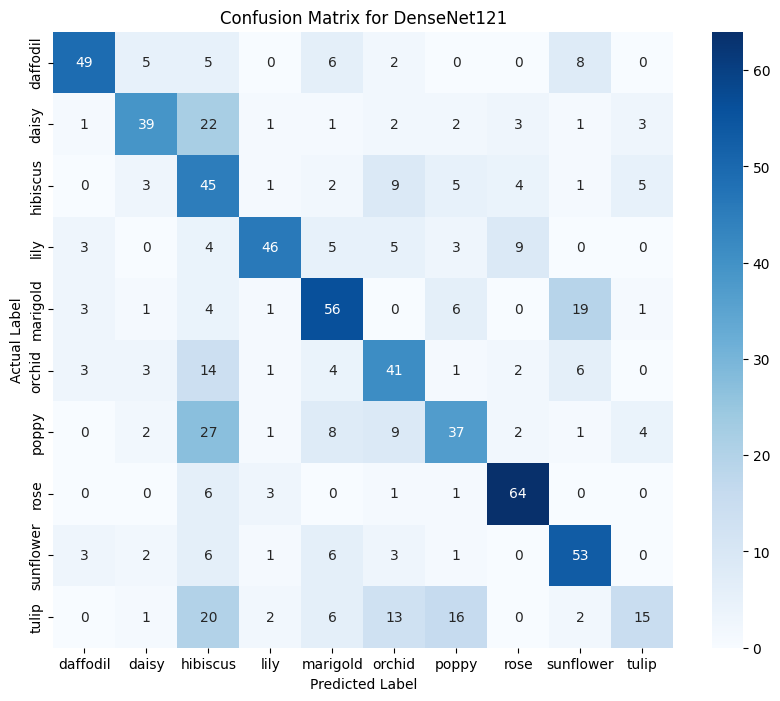

Classification Report for DenseNet121
              precision    recall  f1-score   support

    daffodil       0.79      0.65      0.72        75
       daisy       0.70      0.52      0.60        75
    hibiscus       0.29      0.60      0.39        75
        lily       0.81      0.61      0.70        75
    marigold       0.60      0.62      0.61        91
      orchid       0.48      0.55      0.51        75
       poppy       0.51      0.41      0.45        91
        rose       0.76      0.85      0.81        75
   sunflower       0.58      0.71      0.64        75
       tulip       0.54      0.20      0.29        75

    accuracy                           0.57       782
   macro avg       0.61      0.57      0.57       782
weighted avg       0.60      0.57      0.57       782



In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import time

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\haika\\AppData\\Local\\Programs\\Microsoft VS Code\\data\\split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_densenet121_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_densenet121', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard, early_stopping]
)
training_time = time.time() - start_time

# Load the best model
model = tf.keras.models.load_model('best_densenet121_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")
print(f"Training Time: {training_time} seconds")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for DenseNet121')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for DenseNet121')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))


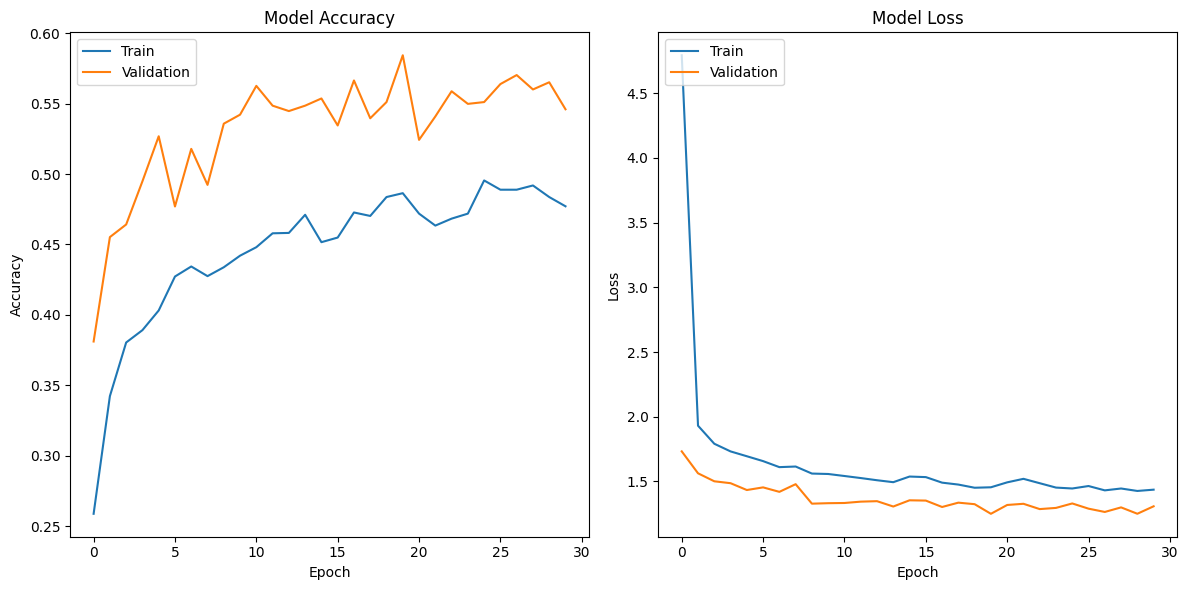

In [12]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()